In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls /content/gdrive/My\ Drive/
root_path = 'gdrive/My Drive/'

import os
os.chdir('gdrive/My Drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
'5.Sequence models'
 apps.csv
 assets
'Aurélien Géron - Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow_ Concepts, Tools, and Techniques to Build Intelligent Systems-O’Reilly Media (2019).pdf'
 best_model_state.bin
'Colab Notebooks'
 David_Carricondo_Resume.pdf
'Documento sin título.gdoc'
 goodread_reviews_dataset.json
 IH_careerpath
 IMG_20190624_004152.jpg
 model_1ltsm.h5
 model_2ltsm.h5
 reviews.csv
 session.wav
 sketch_data
 variable

In [2]:
!pip install -qq transformers

     |████████████████████████████████| 778kB 2.8MB/s 
     |████████████████████████████████| 1.1MB 13.6MB/s 
     |████████████████████████████████| 890kB 20.6MB/s 
     |████████████████████████████████| 3.0MB 25.2MB/s 


In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import json
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
%config InlineBackend.figure_format='retina'


sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Importing the google app reviews:


In [4]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

df = pd.read_csv("reviews.csv")
df.head()

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/gdrive/My Drive/apps.csv
100% 134k/134k [00:00<00:00, 17.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/gdrive/My Drive/reviews.csv
7.17MB [00:00, 63.3MB/s]


,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


Text(0.5, 0, 'Review score')

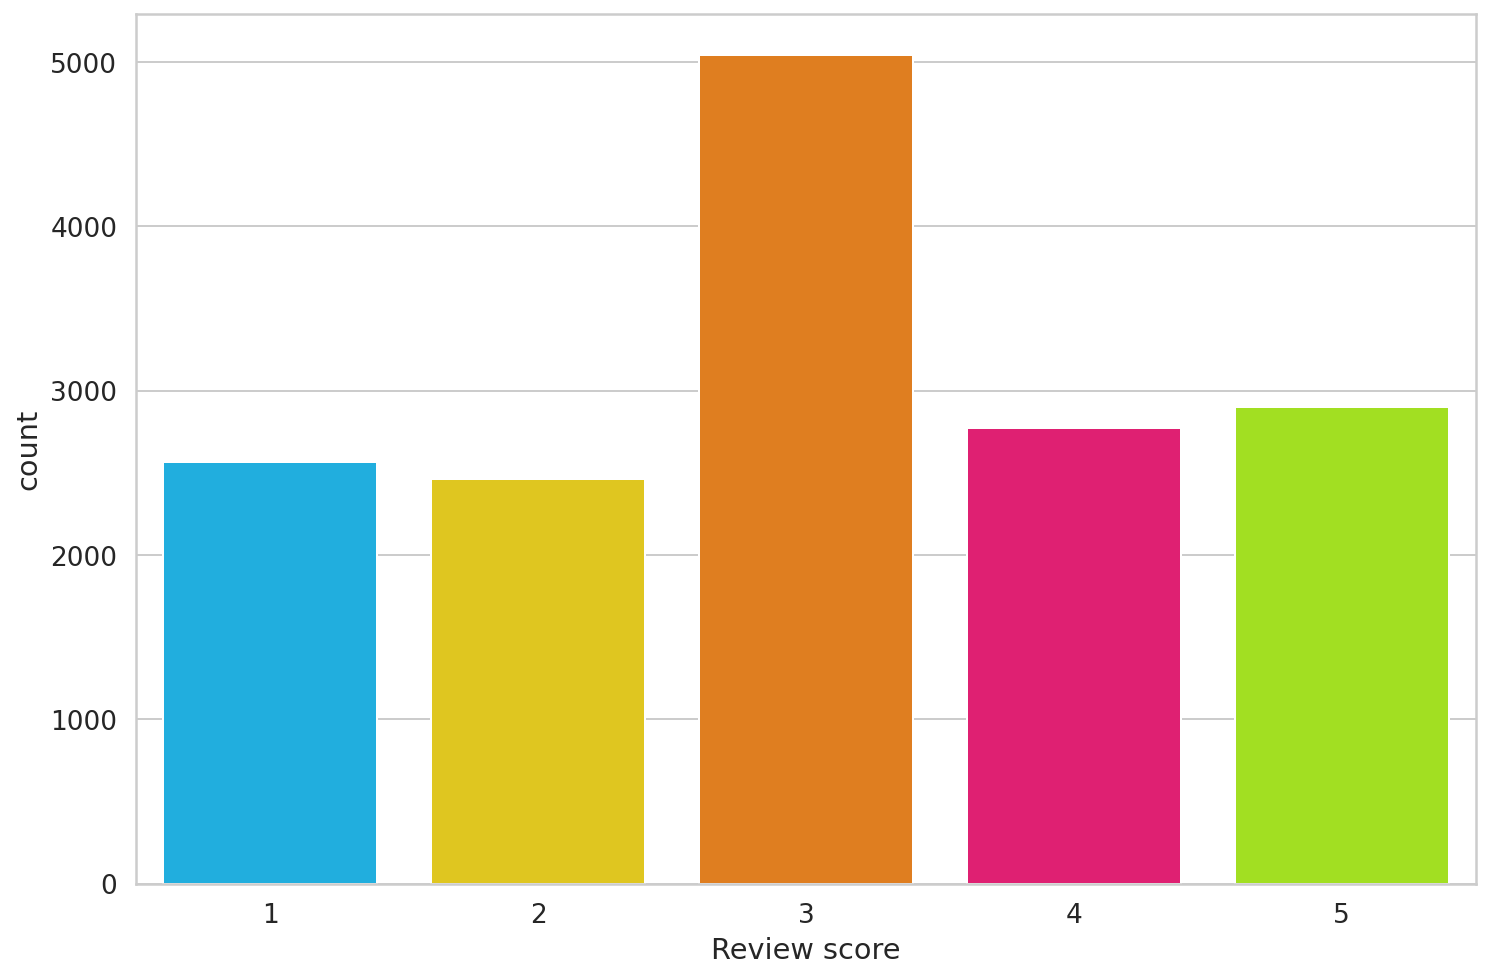

In [5]:
sns.countplot(df.score)
plt.xlabel('Review score')

Transform data into categorical 'positive', 'neutral', and 'negative' reviews:

In [6]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

df['sentiment'] = df.score.apply(to_sentiment)


[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

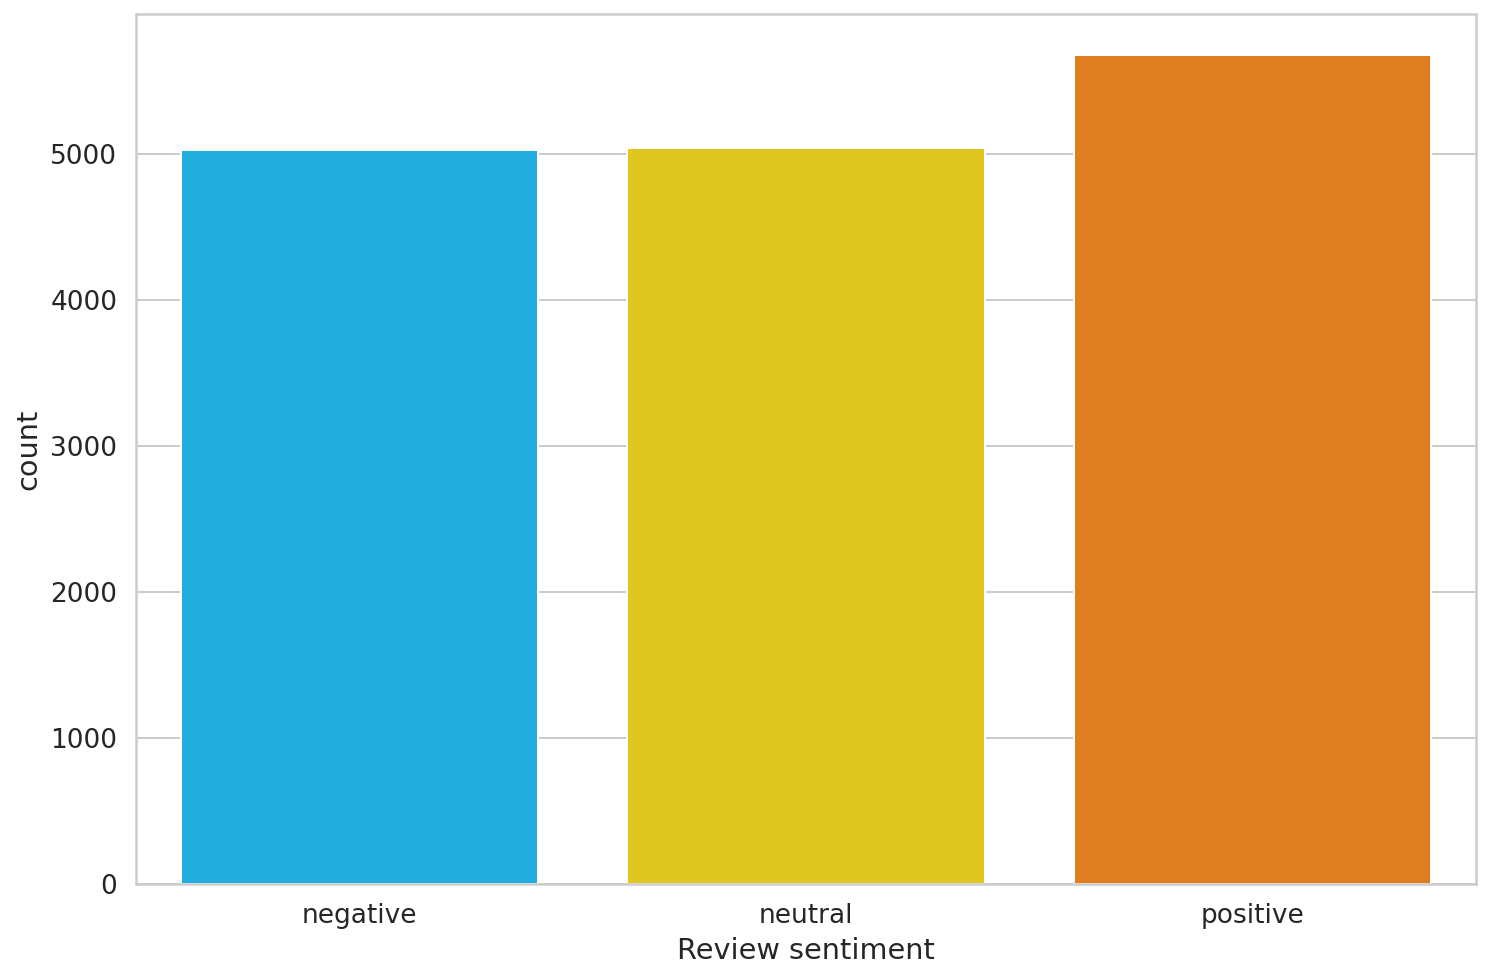

In [7]:
class_names = ['negative', 'neutral', 'positive']

ax = sns.countplot(df.sentiment)
plt.xlabel('Review sentiment')
ax.set_xticklabels(class_names)

## Data preprocessing

In [8]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

Here we use the pre-trained model bert case sensitive model, so words in uppercase have more emphasis and importance in the analysis (everybody knows that uppercase is just shouting in the internet...)

The module transformers have also a tokenizer for bert with requires some special tokenization:
  - Separator tokens
  - Padding
  - Attention masks (arrays of 0 and 1s (padded and real tokens))
  

In [9]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Example:

In [10]:
sample = 'Will I ever get a job in data? No, never. NEVER!'

#Convert text to tokens
tokens = tokenizer.tokenize(sample)
#Convert the tokens to ids:
token_ids = tokenizer.convert_tokens_to_ids(tokens)

In [11]:
print(f'Sentence: {sample}')
print(f'  Tokens: {tokens}')
print(f'     Ids: {token_ids}')

Sentence: Will I ever get a job in data? No, never. NEVER!
  Tokens: ['Will', 'I', 'ever', 'get', 'a', 'job', 'in', 'data', '?', 'No', ',', 'never', '.', 'NE', '##VE', '##R', '!']
     Ids: [3100, 146, 1518, 1243, 170, 2261, 1107, 2233, 136, 1302, 117, 1309, 119, 26546, 17145, 2069, 106]


We need to add the special tokens, namely [CLS] at the beggining of each sentence, [SEP] as a separator token between each sentence, and [UNK] as the unknown token for tokens outside of the training set.

We can use the encode_plus method for this:

In [12]:
encoding = tokenizer.encode_plus(
    sample, 
    max_length=32,
    truncation=True,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt' #PyTorch tensors
)

In [13]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [14]:
encoding['input_ids']

tensor([[  101,  3100,   146,  1518,  1243,   170,  2261,  1107,  2233,   136,
          1302,   117,  1309,   119, 26546, 17145,  2069,   106,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])

In [15]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [16]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'Will',
 'I',
 'ever',
 'get',
 'a',
 'job',
 'in',
 'data',
 '?',
 'No',
 ',',
 'never',
 '.',
 'NE',
 '##VE',
 '##R',
 '!',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

Choosing the max length for the reviews dataset:

In [17]:
token_lens = []

for rev in df.content:
  tokens = tokenizer.encode(rev, max_length=250, truncation=True)
  token_lens.append(len(tokens))

Text(0.5, 0, 'Token count')

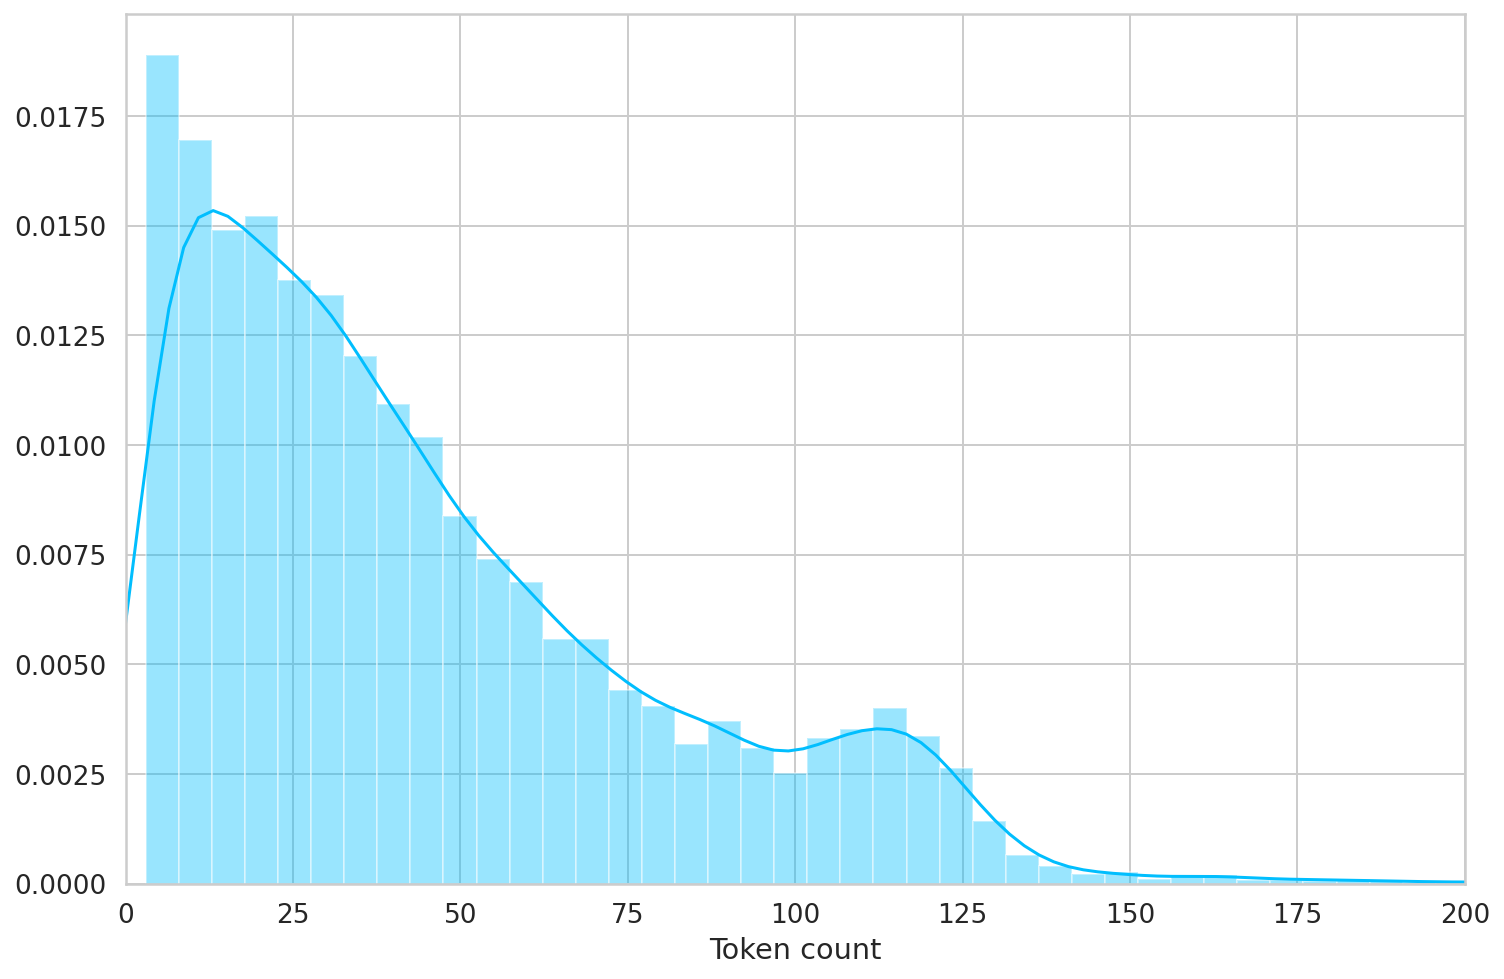

In [18]:
sns.distplot(token_lens)
plt.xlim([0,200])
plt.xlabel('Token count')

In [19]:
MAX_LEN = 160

Create a PyTorch dataset:

In [20]:
class GPReviewDataset(Dataset):
  
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    #The class mainly rely on the next lines:
    encoding = self.tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=self.max_len,
        truncation=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    return {
        'review_text': review,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
    }


Now we can split the data into training, validation and test sets:

In [21]:
df_train, df_test = train_test_split(
    df, test_size=0.1, random_state=RANDOM_SEED)

df_val, df_test = train_test_split(
    df_test, test_size=0.5, random_state=RANDOM_SEED)

df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

Finally, we need a PyTorch dataloader:

In [22]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
      reviews=df.content.to_numpy(),
      targets=df.sentiment.to_numpy(),
      tokenizer=tokenizer,
      max_len=max_len
  )

  return DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=4
  )

BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [23]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [24]:
print(data['input_ids'].shape)

print(data['attention_mask'].shape)

print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


##Modelling with the bert base model

In [25]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [26]:
#using the example text
last_hidden_State, pooled_output = bert_model(
    input_ids=encoding['input_ids'],
    attention_mask=encoding['attention_mask']
)

In [27]:
last_hidden_State.shape

torch.Size([1, 32, 768])

In [28]:
bert_model.config.hidden_size

768

Let's create now a sentiment classifier starting from the last hidden state of the bert model:

In [29]:
class SentimentCLassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentCLassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
        input_ids=input_ids, 
        attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

Now we can create an instance of the model and run it in the GPU by using the method .to(device)

In [30]:
model = SentimentCLassifier(len(class_names))
model = model.to(device)

Let's set up the training optimizer (AdamW which takes care of the weight decay in deep nn), the loss function and the number of epochs:

In [35]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

In [36]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  '''
  Function that train one epoch
  '''
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds==targets)
    losses.append(loss.item())

    loss.backward()
    #Here we use clipping gradients to avoid exploding gradients:
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double()/n_examples, np.mean(losses)


THe next function is similar than the previous one but without the backpropagation, and therefore, is used for inference. We achieve this by using torch.no_grad()

In [37]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Now we can loop:

In [38]:
%%time

#Default dictionaries create a key if it does not exist when calling it
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch +1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
      model, 
      val_data_loader,
      loss_fn,
      device,
      len(df_val)
  )

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.6033359929145593 accuracy 0.7519582245430809
Val loss 0.5222771945595741 accuracy 0.8005082592121983

Epoch 2/10
----------
Train loss 0.29955309360344845 accuracy 0.893162091595512
Val loss 0.4883337114751339 accuracy 0.852604828462516

Epoch 3/10
----------
Train loss 0.19104484128965482 accuracy 0.9409357137816668
Val loss 0.6722708533704281 accuracy 0.8602287166454893

Epoch 4/10
----------
Train loss 0.12742740916126066 accuracy 0.9648578081998448
Val loss 0.7479611486196518 accuracy 0.8691232528589581

Epoch 5/10
----------
Train loss 0.09812762906131572 accuracy 0.9730435396231741
Val loss 0.7365349070727825 accuracy 0.878017789072427

Epoch 6/10
----------
Train loss 0.07399504497630467 accuracy 0.97911227154047
Val loss 0.7901921274513006 accuracy 0.878017789072427

Epoch 7/10
----------
Train loss 0.05517696947044363 accuracy 0.9837696704537436
Val loss 0.8051984363794327 accuracy 0.8818297331639137

Epoch 8/10
----------
Train loss 0.051518

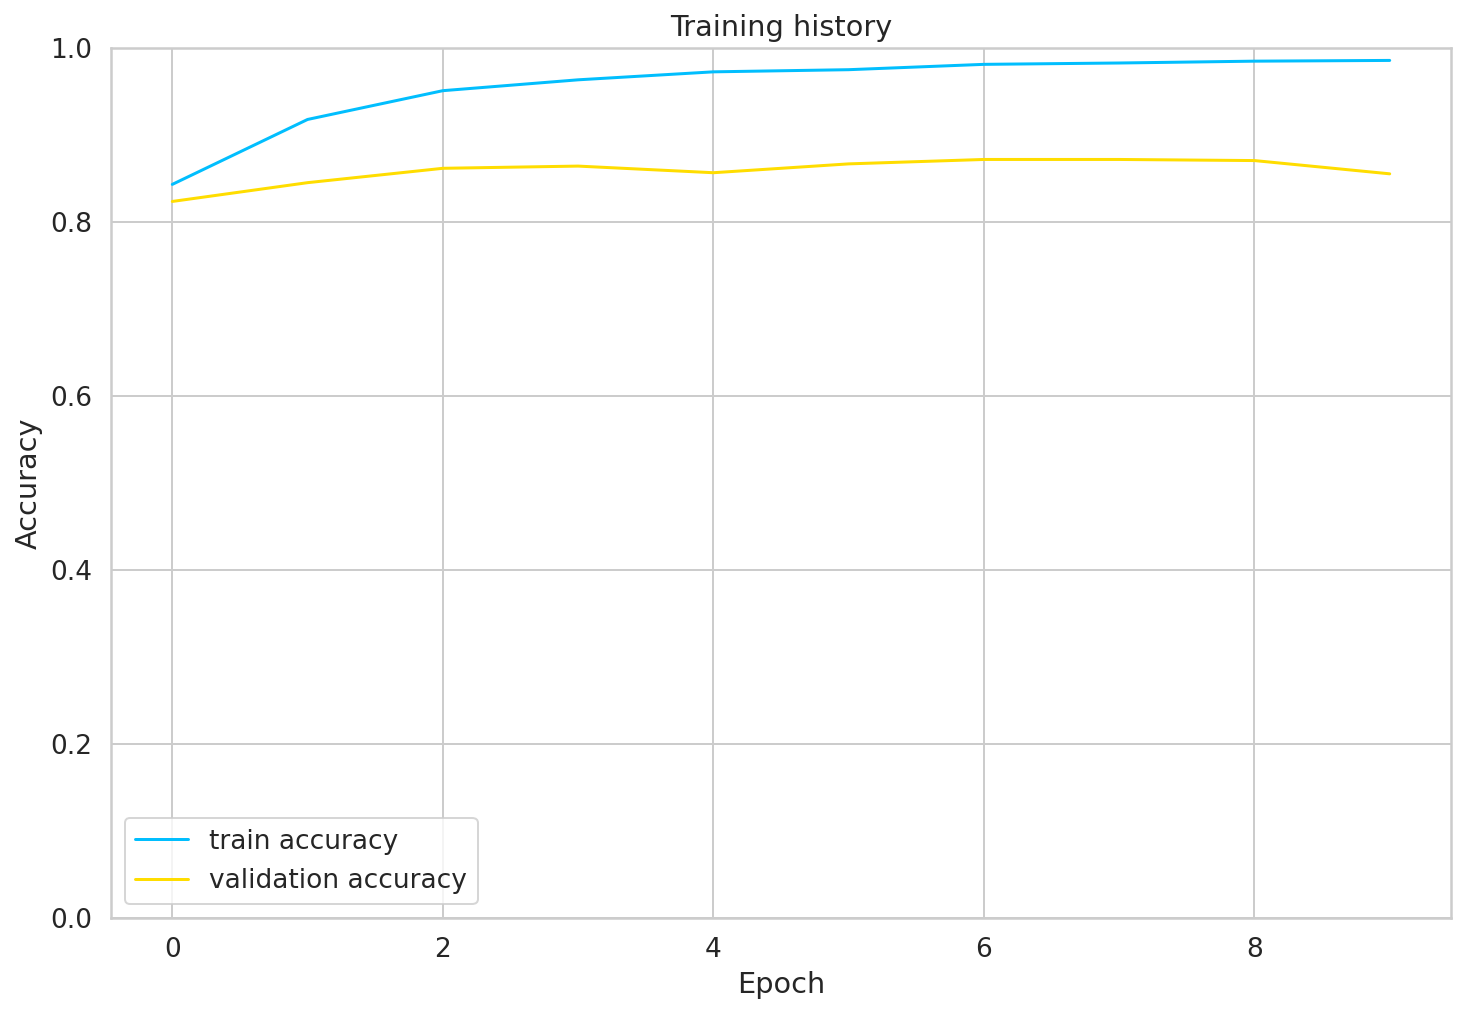

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
#To use the stored model:

# model = SentimentClassifier(len(class_names))
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

##Model evaluation

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test))

test_acc.item()

0.8781725888324873

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()

  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.88      0.87      0.87       245
     neutral       0.82      0.85      0.83       254
    positive       0.94      0.91      0.92       289

    accuracy                           0.88       788
   macro avg       0.88      0.88      0.88       788
weighted avg       0.88      0.88      0.88       788



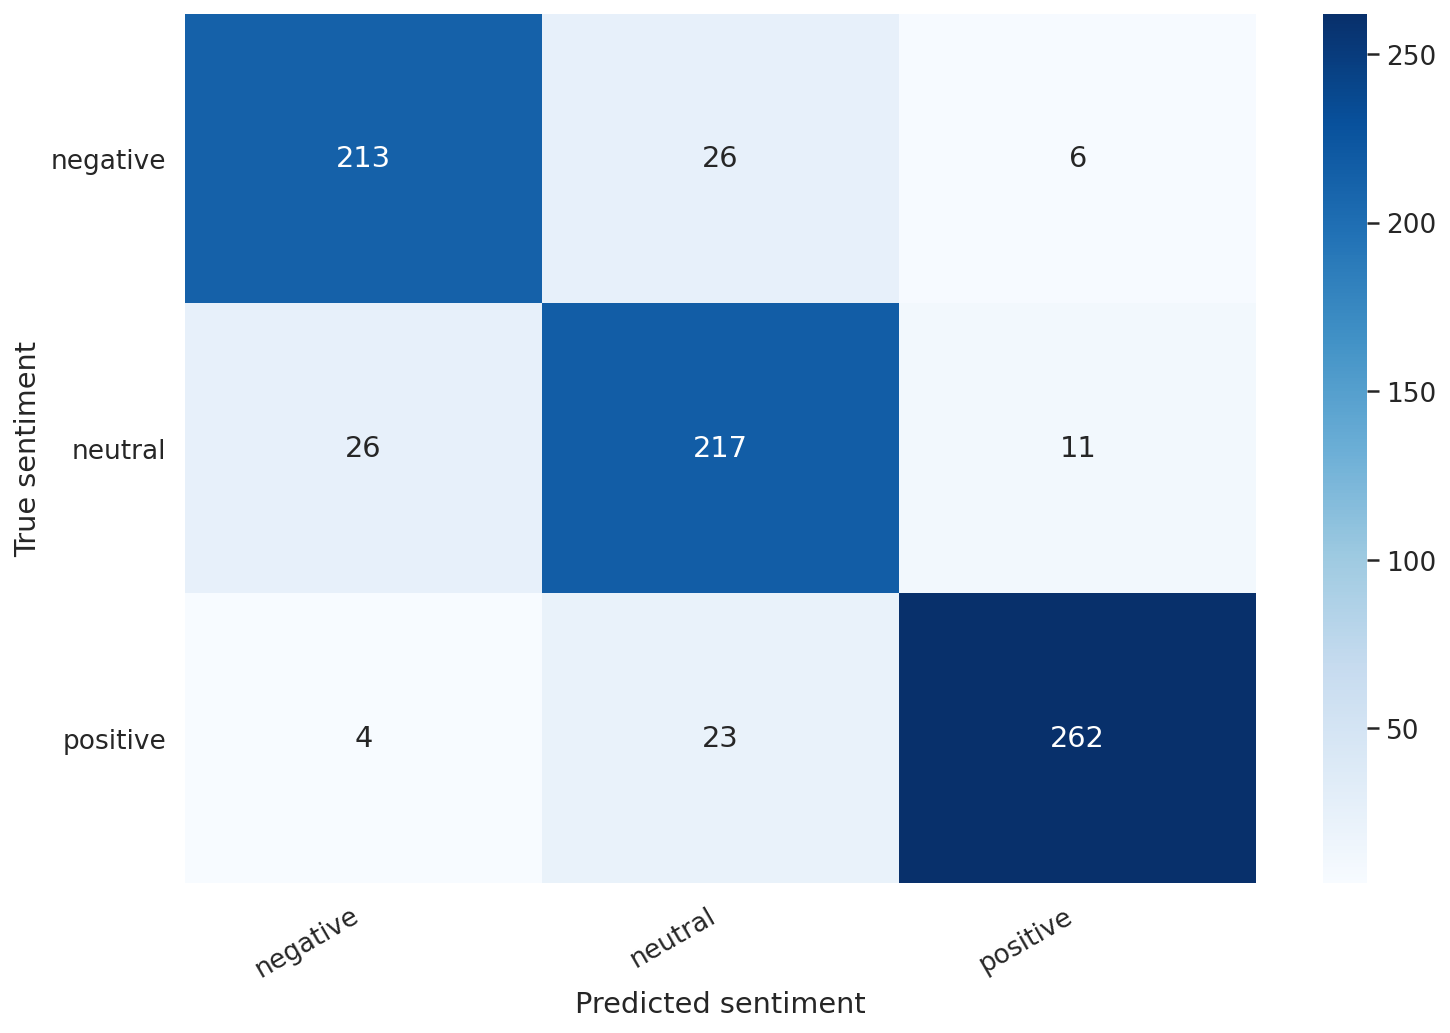

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
#Example from test data:
idx = 22

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

I love this app but recently it has been freezing every time i add a
new task. It's updated and i even reinstalled it yet it is still
happening.

True sentiment: negative


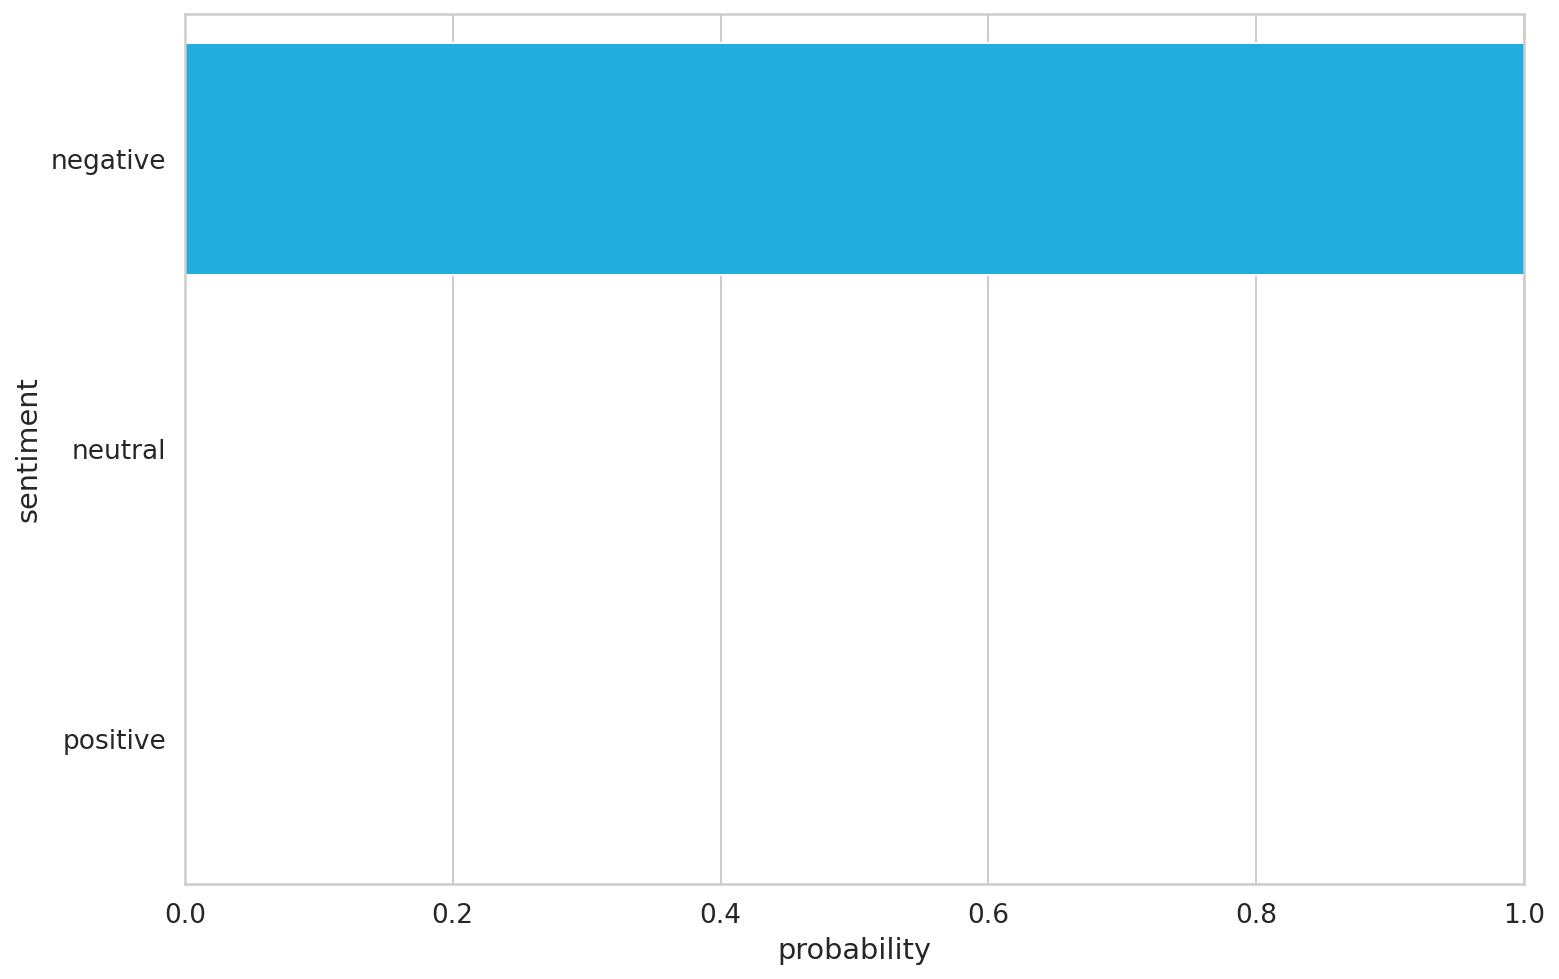

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [ ]:
#Raw data: 

review_text = 'All the apps suck, except for this one'

encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  truncation=True,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')

print(f'Sentiment  : {class_names[prediction]}')

Review text: All the apps suck, except for this one
Sentiment  : positive
